# Demo for Compressed Sensing MRI Reconstruction

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import sigpy
import sigpy.mri

from cs import *

np.random.seed(0)

### Utils

In [13]:
def generate_sampling_mask(size, sample_fraction=0.5, sampling_scheme='variable-density', sampling_dim_option='1D'):

    num_rows, num_cols = size
    mask = np.zeros((num_rows, num_cols))
    
    if sampling_dim_option == '1D':

        if sampling_scheme == 'uniform':
            pmf = None
        
        elif sampling_scheme == 'variable-density':

            center_fraction = 0.08
            assert sample_fraction > center_fraction

            num_center_cols = int(center_fraction * num_cols)
            center_cols_range = (num_cols // 2 - num_center_cols // 2,  num_cols // 2 + num_center_cols // 2)
            mask[:, center_cols_range[0] : center_cols_range[1]] = 1
            
            pmf = np.ones(num_cols)
            pmf[center_cols_range[0] : center_cols_range[1]] = 0
            pmf = pmf / pmf.sum()
            
            sample_fraction = sample_fraction - center_fraction

        num_sample_lines = int(sample_fraction * num_cols)
        sampled_lines = np.random.choice(np.arange(num_cols), size=num_sample_lines, replace=False, p=pmf)        
        mask[:, sampled_lines] = 1

    elif sampling_dim_option == '2D':

        if sampling_scheme == 'uniform':
            pmf = None
        
        elif sampling_scheme == 'variable-density':
            # TODO
            pass
        
        grid_i, grid_j = np.meshgrid(np.arange(num_rows), np.arange(num_cols), indexing='ij')
        kspace_coords = np.stack((grid_i.flatten(), grid_j.flatten()), axis=1)
        num_samples = int(sample_fraction * (num_rows * num_cols))
        idxs = np.random.choice(np.arange(num_rows * num_cols), size=num_samples, replace=False, p=pmf)
        sampled_coords = kspace_coords[idxs]
        mask[sampled_coords[:, 0], sampled_coords[:, 1]] = 1

    return mask.astype(bool)

def calc_lipschitz_const(mask):
    A = sigpy.mri.linop.Sense(mps=np.ones_like(mask, dtype=np.complex64), weights=mask.astype(np.float32))
    max_eig = sigpy.app.MaxEig(A.H * A, dtype=np.complex64, max_iter=30, show_pbar=True).run()
    lipschitz_estim = 2 * max_eig
    return lipschitz_estim

### Load data

In [14]:
# Create Shepp-Logan phantom image and simulate k-sapce measurement
image_gt = shepp_logan_phantom().astype(np.float64)
image_gt = resize(image_gt, (256, 256), anti_aliasing=True)

mask = generate_sampling_mask(image_gt.shape, sample_fraction=0.5)
kspace = fft2c(image_gt) * mask.astype(np.int8)
image_zf = ifft2c(kspace)  # Zero-filled reconstruction baseline

kspace = np.expand_dims(kspace, axis=0)
mask = np.expand_dims(mask, axis=0)

# # Display
# fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# axs[0].imshow(image_gt, cmap='gray')
# axs[1].imshow(mask, cmap='gray')
# axs[2].imshow(np.abs(image_zf), cmap='gray')
# [ax.axis('off') for ax in axs]
# plt.show()

### Reconstruction

100%|██████████| 250/250 [00:07<00:00, 35.02it/s]


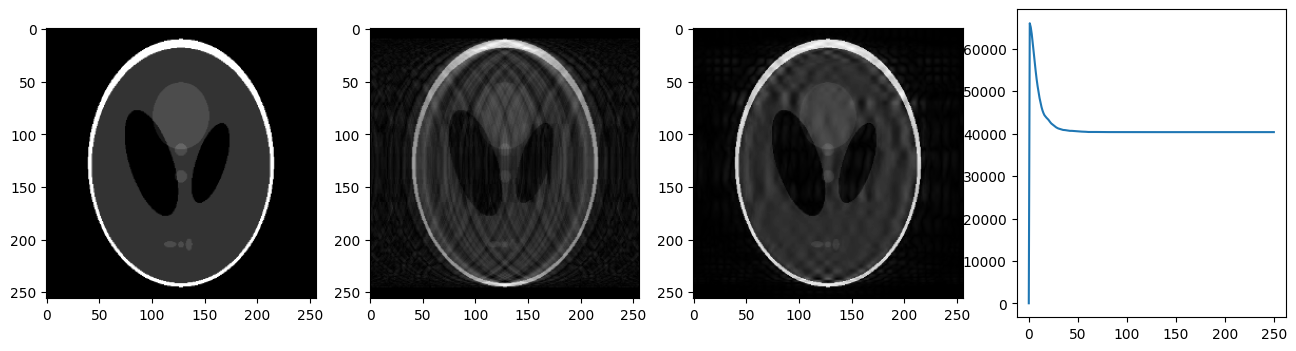

In [18]:
# Define forward operator
forward_op = ForwardOperator(mask)

# Use nonlinear CG solver
# objective = Objective(kspace, forward_op, lambda_l1=5e3)
# solver = NLCGSolver(max_iters=50)

# Or use FISTA solver
objective = Objective(kspace, forward_op, lambda_l1=1e-2)
lipschitz_estim = calc_lipschitz_const(mask)
solver = ISTASolver(num_iters=250, lipschitz_estim=lipschitz_estim, fast=True)

# Reconstruct
image_estim, loss_curve = solver.minimize(objective)

# Display
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(image_gt, cmap='gray')
axs[1].imshow(np.abs(image_zf).squeeze(), cmap='gray')
axs[2].imshow(np.abs(image_estim).squeeze(), cmap='gray')
axs[3].plot(loss_curve)
plt.show()